## DeiT Cross Entropy with Reweight Experiment

In [172]:
import os
import sys
import yaml
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
import time
from torch.utils.data import DataLoader

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%pip install wandb -qU
%matplotlib inline

# Get the current working directory
notebook_dir = notebook_dir = os.path.dirname(os.path.abspath("__file__"))  
project_dir = os.path.abspath(os.path.join(notebook_dir, '..')) 
if project_dir not in sys.path:
    sys.path.append(project_dir)

from src import (get_transforms, load_data, split_data, set_seeds, 
                 verify_splits, verify_data, plot_species_grid,
                 verify_loader_transforms)
from src.data_utils import ImagesDataset, get_transforms_transformer
from src.models import build_deit_model
from src.train import setup_training, evaluate_deit, train_deit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Note: you may need to restart the kernel to use updated packages.


In [173]:
%pip install sympy==1.13.1


Note: you may need to restart the kernel to use updated packages.


In [174]:
%pip install transformers

Note: you may need to restart the kernel to use updated packages.


### **Set up your experiment**

Copy this notebook. Rename it, but keep it in `notebooks/`. To update any settings, params, and/or hyperparams make a copy of `configs/default.yaml`, rename it and call your new `.yaml` below. Be sure to keep it in `configs/`

In [175]:
# Locate the YAML file relative to the notebook's location
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# You need to update this path to your new .yaml file
config_path = os.path.join(notebook_dir, "../configs/deit_CE_reweight.yaml")

# Load the YAML file
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

In [176]:
print(torch.__version__)
print(torch.backends.mps.is_available())
device = config["device"]

2.5.1
True


### **Build the datasets**

#### Load the data
Note: your data file should be hidden in the repo (.gitignore) but make sure to set it up locally like:

`wildlife/data/givens/test_features/[images...]`

`wildlife/data/givens/train_features/[images...]`

`wildlife/data/givens/train_features.csv`

`wildlife/data/givens/test_features.csv`

In [177]:

train_features, test_features, train_labels, species_labels = load_data()

#### Augment Data

In [178]:
# Get transforms
train_transforms, val_transforms = get_transforms_transformer(config)
print(train_transforms)
print(val_transforms)

Compose(
    Resize(size=[480, 480], interpolation=bilinear, max_size=None, antialias=True)
    Lambda()
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[0.0, 0.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
    ToTensor()
)
Compose(
    Resize(size=[480, 480], interpolation=bilinear, max_size=None, antialias=True)
    Lambda()
    ToTensor()
)


#### Split into train and evaluation sets

We need to ensure that sites are mutually exclusive between the training and validation sets, meaning no site should appear in both sets. This ensures a proper stratification based on site.

In [179]:
set_seeds(config["experiment"]["seed"])
X_train, X_val, y_train, y_val = split_data(
    train_features, train_labels, type='sites')

In [180]:
# Helper function (Optional)
# verify_splits(X_train, y_train, X_val,  y_val)

In [181]:

# # Count the number of samples for each class in the training set
# class_counts = y_train.sum(axis=0)  # Sum column-wise to get the count for each class

# # Convert to a dictionary for visualization
# class_counts_dict = class_counts.to_dict()

# # Sort class counts in descending order and retain both labels and counts
# sorted_counts = sorted(class_counts_dict.items(), key=lambda x: x[1], reverse=True)

# # Extract class labels and counts separately after sorting
# labels, counts = zip(*sorted_counts)

# # Plot the distribution
# plt.figure(figsize=(7, 6))
# plt.bar(labels, counts, edgecolor='black', color='skyblue')
# plt.xlabel("Class Labels")
# plt.ylabel("Number of Samples")
# plt.title("Training Data Distribution")
# plt.xticks(rotation=45, ha="right")
# plt.tight_layout()
# plt.show()



#### Set up DataLoader

In [182]:
# verify transformations in dataloaders (Optional)
# verify_loader_transforms(train_loader, title_type='train')
# verify_loader_transforms(val_loader, title_type='validate')

# set_seeds(config["experiment"]['seed'])

### **Training**


#### Define the model
Note: If you build a new model, add it to `models.py` and update the block below. And update your `.yaml` config.

In [183]:
# set_seeds(config["experiment"]['seed'])
# model = build_resnet50_basic(
#     num_classes = config["model"]["num_classes"],
#     hidden_units1 = config["model"]["hidden_units1"],
#     dropout = config["model"]["dropout"],
#     freeze_backbone = config["model"]["freeze_backbone"]
# )
# model = model.to(device)

In [184]:
set_seeds(config["experiment"]['seed'])
feature_extractor, model =  build_deit_model(
    num_classes = config["model"]["num_classes"],
    dropout = config["model"]["dropout"],
    hidden_units1=config["model"]["hidden_units1"],
    freeze_backbone = config["model"]["freeze_backbone"]
)
model = model.to(device)


/Users/evaball/opt/miniconda3/envs/dlfinal/lib/python3.12/site-packages/transformers/models/deit/feature_extraction_deit.py:28: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [185]:
# set_seeds(config["experiment"]['seed'])
# feature_extractor, model =  build_swin_model(
#     num_classes = config["model"]["num_classes"],
#     dropout = config["model"]["dropout"],
#     freeze_backbone = config["model"]["freeze_backbone"]
# )
# model = model.to(device)

#### Define your criterion and optimizer
Note: If needed up date these in `train.py` and update your `.yaml` config.

In [186]:
set_seeds(config["experiment"]['seed'])
class_counts = y_train.sum(axis=0).values
# print(class_counts)

criterion, optimizer = setup_training(
        model, 
        criterion=config["train"]["criterion"],
        optimizer=config["train"]["optimizer"], 
        lr=config["train"]["lr"], 
        momentum=config["train"]["momentum"],
        gamma=config["train"]["gamma"],
        alpha=config["train"]["alpha"],
        device=device,
        weight_decay=config["train"]["weight_decay"],
        cls_num_list=class_counts)
# print(config["train"]["alpha"])
print(optimizer)


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0.001
)


Class distribution and difficulty 

In [187]:
set_seeds(config["experiment"]["seed"])

# Create datasets
train_dataset = ImagesDataset(
    features=X_train, 
    labels=y_train, 
    feature_extractor=feature_extractor, 
    transform=train_transforms,
    device=device)
val_dataset = ImagesDataset(
    features=X_val, 
    labels=y_val, 
    feature_extractor=feature_extractor, 
    transform=val_transforms,
    device=device)

# # Create datasets
# train_dataset = ImagesDataset(
#     features=X_train, 
#     labels=y_train, 
#     device=device)
# val_dataset = ImagesDataset(
#     features=X_val, 
#     labels=y_val, 
#     device=device)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config["train"]["batch_size"], 
    shuffle=True, pin_memory=True)
val_loader = DataLoader(
    val_dataset, 
    batch_size=config["train"]["batch_size"], 
    shuffle=False, pin_memory=True)


In [188]:
# Print shapes for verification (Optional)
print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")

Training set: 13171 samples
Validation set: 3317 samples


#### Set up logging

In [189]:
wandb.require()
wandb.login()

True

In [190]:
# ✨ W&B: Initialize a new run to track this model's training
wandb.init(project="wildlife", config=config)

#### Run the train / eval loop

In [191]:

train_losses = []  # To store average training loss per epoch
val_losses = []    # To store validation loss per epoch
set_seeds(config["experiment"]['seed'])

start_time = time.time()
for epoch in range(config["train"]["epochs"]):
# for epoch in range(2):
    # Training step
    avg_train_loss = train_deit(
        model, 
        train_loader, criterion, optimizer, 
        epoch, config, device=device)
    train_losses.append(avg_train_loss)  # Store avg training loss
    print(f"Epoch {epoch+1}/{config["train"]["epochs"]} - Avg Train Loss: {
        avg_train_loss:.12f}")
    
    # Evaluation step
    eval_metrics = evaluate_deit(
        model, val_loader, criterion, 
        config, epoch+1, device=device)
    val_losses.append(eval_metrics["loss"])  # Store validation loss
    print(f"Epoch {epoch+1}/{config["train"]["epochs"]} - Eval Loss: {
        eval_metrics['loss']:.12f}, Eval Acc: {eval_metrics['accuracy']:.2f}%")

end_time = time.time()
duration = end_time - start_time
wandb.log({"duration": duration})


Starting training for epoch 1
Epoch [1/4], Step [100/824], Loss: 1.446636199951
Epoch [1/4], Step [200/824], Loss: 1.497945427895
Epoch [1/4], Step [300/824], Loss: 1.081855416298
Epoch [1/4], Step [400/824], Loss: 1.765952706337
Epoch [1/4], Step [500/824], Loss: 0.954420626163
Epoch [1/4], Step [600/824], Loss: 1.160431265831
Epoch [1/4], Step [700/824], Loss: 0.932896316051
Epoch [1/4], Step [800/824], Loss: 0.985715508461
Epoch 1/4 - Avg Train Loss: 1.184891799591
Eval - Loss: 1.2312, Accuracy: 46.25%, Precision: 0.47, Recall: 0.46, F1: 0.45, MacroF1: 0.46
Epoch 1/4 - Eval Loss: 1.231168534607, Eval Acc: 46.25%
Starting training for epoch 2
Epoch [2/4], Step [100/824], Loss: 0.722858905792
Epoch [2/4], Step [200/824], Loss: 0.728217244148
Epoch [2/4], Step [300/824], Loss: 0.752044320107
Epoch [2/4], Step [400/824], Loss: 1.479489564896
Epoch [2/4], Step [500/824], Loss: 0.967109620571
Epoch [2/4], Step [600/824], Loss: 1.026784181595
Epoch [2/4], Step [700/824], Loss: 0.9353624582

If you are done logging or you want to run the experiment again, finish with the block below. But if you think you might want to submit this run to the competition, don't finish logging until the end once you've added the competition score.

In [192]:
# ✨ W&B: Mark the run as complete (Or wait until the end of notebook)
wandb.finish()

duration,▁
epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆█████████
eval_accuracy,▁█▃█
eval_f1,▁█▅▇
eval_loss,▂▁█▆
eval_macro_f1,▁█▅▇
eval_precision,▁▇██
eval_recall,▁█▃█
f1_antelope_duiker,▃█▁▅
f1_bird,▁█▁█
f1_blank,▁█▇▇


---


### **Explore Experiment** 

In [193]:
# set to True to explore and potentially submit your results 
explore = True

#### Learning Curve

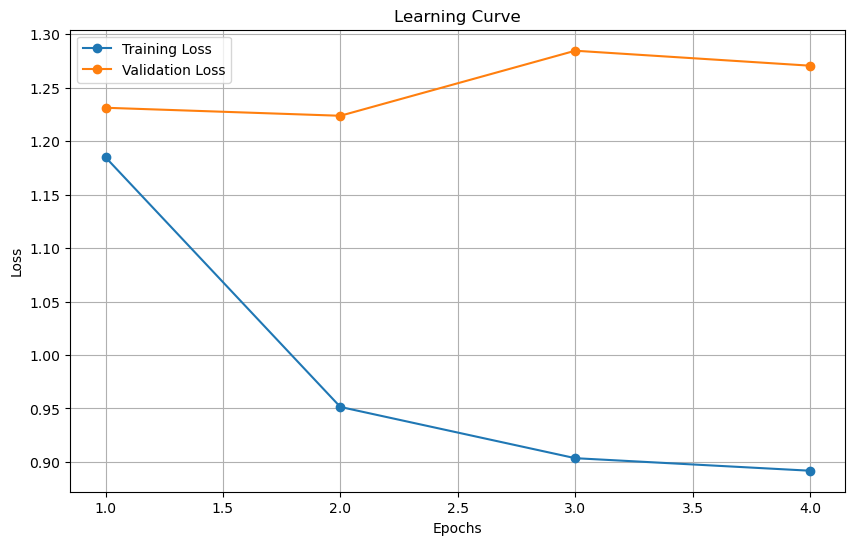

In [194]:
if explore:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, config["train"]["epochs"]+1), train_losses, label="Training Loss", marker="o")
    plt.plot(range(1, config["train"]["epochs"]+1), val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

#### Class Distribution  

True Labels from Training Set

In [195]:
if explore:
    print("True labels (training):")
    print(y_train.idxmax(axis=1).value_counts())   

True labels (training):
civet_genet         2055
monkey_prosimian    1959
antelope_duiker     1867
leopard             1859
blank               1800
rodent              1535
bird                1324
hog                  772
Name: count, dtype: int64


True and Predicated Labels from Validation Set

In [196]:
if explore:
    # Extract predictions and true labels from eval_metrics
    all_preds = eval_metrics["all_preds"]
    all_labels = eval_metrics["all_labels"]

    # Convert all_preds to DataFrame and map to class names
    preds_df = pd.DataFrame(all_preds, columns=["predicted_class"])
    preds_df["predicted_label"] = preds_df["predicted_class"].map(
        lambda idx: species_labels[idx]
    )

    # Convert all_labels to DataFrame and map to class names
    labels_df = pd.DataFrame(all_labels, columns=["true_class"])
    labels_df["true_label"] = labels_df["true_class"].map(
        lambda idx: species_labels[idx]
    )

    # Combine predictions and true labels for analysis
    results_df = pd.concat([preds_df, labels_df], axis=1)

    # Display value counts for predicted and true labels
    print("Predicted labels (eval):")
    print(results_df["predicted_label"].value_counts())

    print("\nTrue labels (eval):")
    print(results_df["true_label"].value_counts())

Predicted labels (eval):
predicted_label
monkey_prosimian    879
blank               829
hog                 311
rodent              309
antelope_duiker     308
civet_genet         250
leopard             225
bird                206
Name: count, dtype: int64

True labels (eval):
true_label
antelope_duiker     607
monkey_prosimian    533
rodent              478
blank               413
leopard             395
civet_genet         368
bird                317
hog                 206
Name: count, dtype: int64


Accuracy per class

In [197]:
if explore:    
    per_class_accuracy = results_df.groupby("true_label").apply(
        lambda x: (x["true_label"] == x["predicted_label"]).mean(), 
    )
    print("Per-Class Accuracy:")
    print(per_class_accuracy)

Per-Class Accuracy:
true_label
antelope_duiker     0.373970
bird                0.201893
blank               0.624697
civet_genet         0.538043
hog                 0.781553
leopard             0.516456
monkey_prosimian    0.701689
rodent              0.322176
dtype: float64


/var/folders/f9/_qvc3zsj1sg4_558kbgxv0d00000gn/T/ipykernel_53376/3812328652.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_class_accuracy = results_df.groupby("true_label").apply(


Confusion Matrix

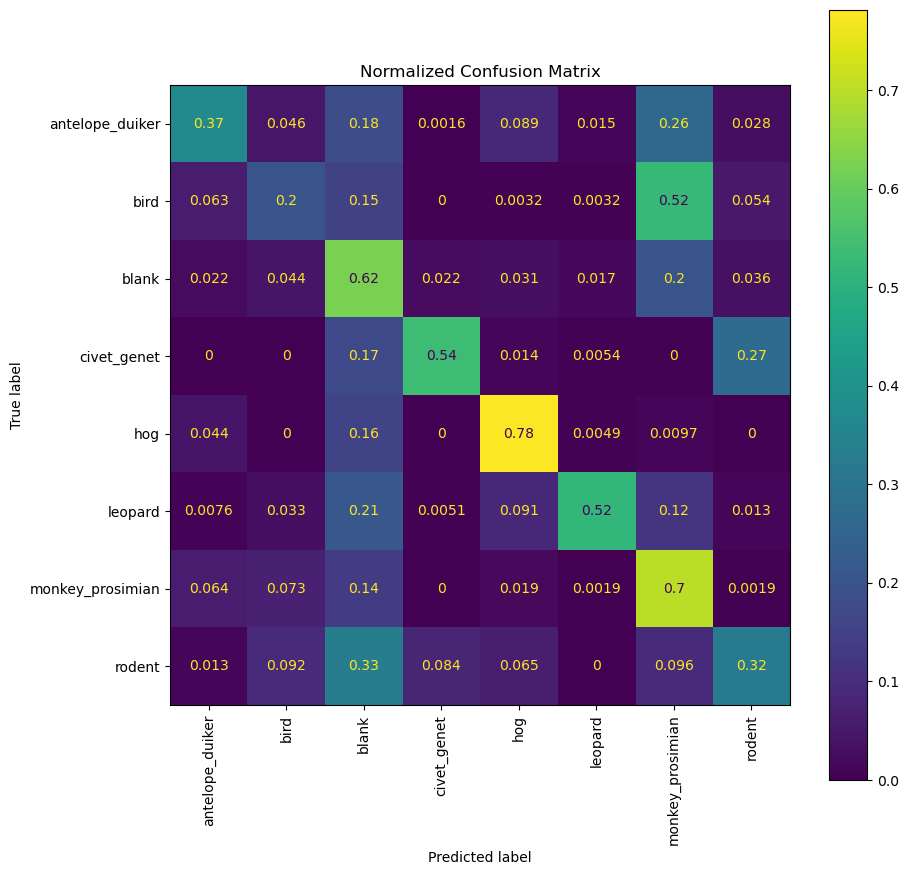

In [198]:
if explore:
    from sklearn.metrics import ConfusionMatrixDisplay

    eval_true = pd.Series(all_labels).apply(lambda x: species_labels[x])
    eval_predictions = pd.Series(all_preds).apply(lambda x: species_labels[x])

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = ConfusionMatrixDisplay.from_predictions(
        eval_true,
        eval_predictions,
        ax=ax,
        xticks_rotation=90,
        colorbar=True,
        normalize='true'
    )
    plt.title("Normalized Confusion Matrix")
    plt.show()